In [12]:
import pandas as pd
import numpy as np
from parameter_estimator import ParameterEstimator as pe
import utils
from collections import deque
import cv2
import random
import math as m

def asspherical(x,y,z):
    r       =  m.sqrt(x*x + y*y + z*z)
    theta   =  m.acos(z/r)*180/ m.pi #to degrees
    phi     =  m.atan2(y,x)*180/ m.pi
    return r,theta,phi
vspherical = np.vectorize(asspherical)

def ascartesian(r, theta, phi):
    theta   = theta * m.pi/180 # to radian
    phi     = phi * m.pi/180
    x = r * m.sin( theta ) * m.cos( phi )
    y = r * m.sin( theta ) * m.sin( phi )
    z = r * m.cos( theta )
    return x, y, z

In [13]:
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header

In [14]:
dist_points = 0.01  # generate points of the robot EE with this distance

In [15]:
observations = dict()
ids = random.choices(list(range(100)), k=100)
for marker_id in ids:
    observations[marker_id] = deque(maxlen=30) 
T_WMs = dict() 
for marker_id in ids:
    r = np.random.normal(3, 0.12, 1)[0]
    theta = np.random.uniform(0, 90, 1)[0]
    phi   = np.random.uniform(0, 360, 1)[0]
    x, y, z = ascartesian(r, theta, phi)
    T_WMs[marker_id]= utils.H_rvec_tvec(np.array([0.0, 0, 0]), np.array([x, y, z]))

In [16]:
theta_all = pe.dhparams["theta_nom"]
d_all = pe.dhparams["d_nom"]
r_all = pe.dhparams["r_nom"]
alpha_all = pe.dhparams["alpha_nom"]
q = np.empty((7,0))

for q1, q2 in zip(traj.T, traj.T[1:]):   # all pairs of joint positions
    T_07_1 = pe.get_T_jk(0, 7, q1, theta_all, d_all, r_all, alpha_all)
    T_07_2 = pe.get_T_jk(0, 7, q2, theta_all, d_all, r_all, alpha_all)
    
    diff = T_07_1[0:3, 3] - T_07_2[0:3, 3]
    dist_total = np.linalg.norm(diff)
    num_steps = int(dist_total // dist_points)
    _q = np.array([np.linspace(q1_i, q2_i, num_steps) for q1_i, q2_i in zip(q1, q2)])
    q = np.hstack((q, _q))

In [17]:
print(np.shape(q))

(7, 4292)


In [18]:
T_W0 = np.array([[-1, 0, 0, 0],
                 [0, -1, 0, 0],
                 [0, 0, 1, 0.36],
                 [0, 0, 0, 1]])

T_7C = utils.Trans(0, 0, 0.281) @ utils.Rz(np.pi)

T_corr = np.array([[ 0,  0, 1, 0],
                   [ -1,  0, 0, 0],
                   [ 0, -1, 0, 0],
                   [ 0,  0, 0, 1]])

In [19]:
listkeys = list(T_WMs.keys())
# print(f"list of keys: {listkeys}")

X = list()
Y = list()
Z = list()
Xm = list()
Ym = list()
Zm = list()

cntr = 0
for qi in q.T:
    T_WM_id = listkeys[0]
    cntr += 1
    if cntr > 30:
        cntr = 0
        listkeys = listkeys[1:]
        if len(listkeys) == 0:
            listkeys = list(T_WMs.keys())
            
    T_WM = T_WMs[T_WM_id]
    
    T_07_i = pe.get_T_jk(0, 7, qi, theta_all, d_all, r_all, alpha_all)
    T_W7_i = T_W0 @ T_07_i
    T_WC_i = T_W7_i @ T_7C
    
    T_CM_i = np.linalg.inv(T_corr) @ np.linalg.inv(T_WC_i) @ T_WM
    
    obs = dict()
    obs['id'] = T_WM_id
    rvec, _ = cv2.Rodrigues(T_CM_i[0:3, 0:3])
    obs['rvec'] = list(rvec.flatten())
    obs['tvec'] = T_CM_i[0:3, 3]
    obs['t'] = 0
    obs['q'] = qi.flatten()
    
    observations[T_WM_id].append(obs)
    
    X.append(T_WC_i[0, 3])
    Y.append(T_WC_i[1, 3])
    Z.append(T_WC_i[2, 3])
    
    Xm.append((T_WC_i @ T_corr @ T_CM_i)[0, 3])
    Ym.append((T_WC_i @ T_corr @ T_CM_i)[1, 3])
    Zm.append((T_WC_i @ T_corr @ T_CM_i)[2, 3])

In [20]:
import pickle
# open a file to store data
observations_file_str = "observations_fake.p"
observations_file = open(observations_file_str, 'wb')
# dump information to that file
pickle.dump(observations, observations_file)
# close the file
observations_file.close()

# open a file to store data
observations_file_str = "observations_fake_marker_pos.p"
observations_file = open(observations_file_str, 'wb')
# dump information to that file
pickle.dump(T_WMs, observations_file)
# close the file
observations_file.close()
print("done")

done


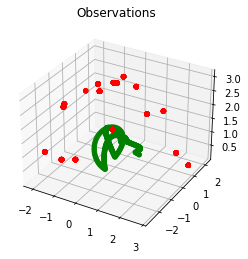

In [21]:
%matplotlib inline 
# widget
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Observations")


ax.scatter(X[:500], Y[:500], Z[:500], c='green')
ax.scatter(Xm[:500], Ym[:500], Zm[:500], c='red')

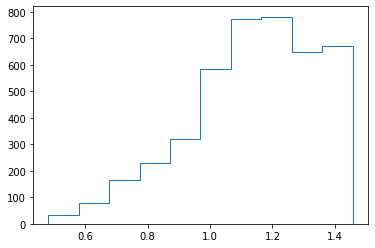

In [22]:
R, Theta, Phi = vspherical(X,Y,Z)

counts, bins = np.histogram(R)
plt.stairs(counts, bins)